# Factor Portfolio Analysis

## Section 1: Preparation

### 1.1 Importing Libraries, Defining Stock Universe & Importing Price History

In [1]:
import time
import requests
import numpy as np
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path
from ib_insync import IB, Stock, util
from datetime import datetime, timedelta
from scipy.stats import ttest_1samp
from scipy.stats import t as student_t
import locale

In [2]:
top100_symbols = [
    "MSFT","AAPL","NVDA","AMZN","AVGO","TSLA","GOOGL", "APP", "MO",
    "JPM","V","LLY","NFLX","XOM","MA","COST","WMT","PG","HD", "BMY",
    "JNJ","ABBV","BAC","UNH","CRM","KO","ORCL","PM","WFC", "INTC",
    "CSCO","IBM","CVX","GE","ABT","MCD","NOW","ACN","DIS", "COF", "PH",
    "MRK","UBER","T","GS","INTU","AMD","VZ","PEP","BKNG", "CEG", "CVS",
    "RTX","ADBE","TXN","CAT","AXP","QCOM","PGR","TMO","SPGI","MS",
    "BA","BSX","NEE","TJX","SCHW","AMGN","HON","C","AMAT", "NEM",
    "UNP","SYK","CMCSA","ETN","LOW","PFE","GILD","DE","DHR", "LMT",
    "ADP","COP","GEV","TMUS","ADI","MMC","LRCX","MDT", "HCA",
    "MU","CB","KLAC","APH","ANET","ICE","SBUX", "CMCSA", "MCK"
]

iwm_top100 = [
    "BE","CRDO","FN","IONQ","SATS","NXT","KTOS","GH","HL","BBIO",
    "RVMD","OKLO","CDE","SPXC","MDGL","U","DY","STRL","ENSG","GTLS",
    "IDCC","SANM","UMBF","MOD","QBTS","RGTI","AVAV","ALKS","HQY","DNA",
    "UMPS","STEM","CMC","IPAR","TTMI","AKRV","WNS","CTRS","AIR","PUB",
    "PLR","RXA","AXGN","HIMS","ZWS","JDGY","CVLT","ORA","SMTC","PS",
    "CADE","IBP","JXN","APLD","FCFS","PIPR","BOOT","BNT","TND","EAT",
    "CWST","MIR","TMHC","RYTM","KSPI","GDS","GATX","BRKT","ASGN","LIC",
    "LEO","VLY","PTCT","INIC","HWC","TOWN","GBCI","LXP","BIPC","LNG",
    "QLYS","CVLT","COST","PRAE","HOMA","CNC","RIOT","ACA","OPCH","BMI",
    "BXC","GPI","INTC","CWAN","PGNY","KNSL","ACHR","POR","BJH"
]

sp500_tickers = top100_symbols

In [3]:
def fetch_ohlcv_ibkr(tickers):
    nest_asyncio.apply()
    ib = IB()
    ib.connect('127.0.0.1', 7496, clientId=3)
    dfs = []
    
    for symbol in tickers:
        contract = Stock(symbol, 'SMART', 'USD')
        bars = ib.reqHistoricalData(
            contract,
            endDateTime = '',
            durationStr='15 Y',
            barSizeSetting='1 day',
            whatToShow='TRADES',
            useRTH=True
        )
        df = util.df(bars)[['date','open','high','low','close','volume']]
        df['ticker'] = symbol
        dfs.append(df)
    
    ib.disconnect()
    return pd.concat(dfs, ignore_index=True)

universe = sp500_tickers
start = time.time()
raw_df = fetch_ohlcv_ibkr(universe)
end   = time.time()
print(f"Price data pulled: {raw_df.shape[0]} rows in {((end-start)/60):.1f} mins")

Price data pulled: 359217 rows in 11.7 mins


### 1.2 Scoring Factors from Metrics

The raw financial metrics are transformed into standardized cross-sectional factor scores across **Value**, **Quality**, and **Momentum**. The resulting composite alpha scores are used for portfolio construction and backtesting.

Tickers are first mapped to sectors using a static map. For each **date × sector** group, the financial metrics are winsorized to the **1st and 99th percentiles** to reduce sensitivity to outliers. We also aligned the direction of the factors such that a higher metric leads to a better outcome. Of note, this included the `ev_ebit` and `debt_to_equity` values, where a negative sign was introduced.

We then computed Z-Scores for the factors:

##### A. Value & Quality (Sector-Neutral)
Within each **date × sector** slice:

$$
z_i = \frac{x_i - \mu_{\text{sector}}}{\sigma_{\text{sector}}}
$$

This removes sector biases and makes comparisons fair within industries.

##### B. Momentum (Universe-Level)
Momentum is standardized **across the entire cross-section**:

$$
z_i^{\text{mom}} = \frac{x_i - \mu}{\sigma}
$$

Each category score is the simple average of its standardized components (i.e. individual metric). The overall alpha score is the equal-weight combination of the factor scores. Equal weighting avoids overfitting and aligns with academic practice. Within every date, alpha scores are binned into 10 quantiles:

- **Decile 10** → strongest factor signals (top 10%)
- **Decile 1** → weakest signals

These deciles form the basis for long-only or long/short portfolio construction.

In [4]:
# === 0. Load full factors table =============================================

df = pd.read_csv("full_factors_table.csv", low_memory=False)
factors = df.copy()

# Ensure proper types & ordering
factors["date"] = pd.to_datetime(factors["date"], errors="coerce")
factors["ticker"] = factors["ticker"].astype(str).str.upper()
factors = factors.sort_values(["date", "ticker"]).reset_index(drop=True)

# === 1. Sector lookup from static map =======================================

sector_df = pd.read_csv("ticker_sector_map.csv")  # cols: ['ticker','sector']
sector_df["ticker"] = sector_df["ticker"].astype(str).str.upper()

# Sanity check: all tickers in factors must exist in sector map
missing = set(factors["ticker"].unique()) - set(sector_df["ticker"].unique())
if missing:
    raise ValueError(f"Missing sector mapping for tickers: {sorted(missing)}")

# Merge sector info
factors = factors.merge(sector_df, on="ticker", how="left")

# Coverage report (per ticker)
ticker_sector = (
    factors[["ticker", "sector"]]
    .drop_duplicates(subset=["ticker"])
    .reset_index(drop=True)
)
coverage = ticker_sector["sector"].notna().mean()
print(f"Sector coverage: {coverage:.2%} of tickers have a non-null sector.")

# If anything is still NaN here, treat as an error (strict mode)
if factors["sector"].isna().any():
    bad = factors.loc[factors["sector"].isna(), "ticker"].unique()
    raise ValueError(f"Unmapped sectors after merge for: {sorted(bad)}")

# === 2. Helper functions ====================================================

def winsorize_series(s, lower=0.01, upper=0.99):
    """Clip extremes to given quantiles."""
    s = s.astype(float)
    if s.notna().sum() < 10:
        return s
    lo, hi = s.quantile([lower, upper])
    return s.clip(lo, hi)

def zscore(s):
    """Standard cross-sectional z-score."""
    s = s.astype(float)
    if s.notna().sum() < 2:
        return pd.Series(np.nan, index=s.index)
    return (s - s.mean()) / s.std(ddof=0)

# === 3. Winsorize raw factor columns ========================================

raw_cols = [
    "book_to_price",
    "ev_ebit",
    "debt_to_equity",
    "gross_margin",
    "operating_margin",
    "roe",
    "mom_6m",
    "obv",
]

# 3a. Coerce raw factor columns to numeric, turning junk into NaN
for col in raw_cols:
    factors[col] = pd.to_numeric(factors[col], errors="coerce")

# 3b. Winsorize within (date, sector) for all columns
factors[raw_cols] = (
    factors
    .groupby(["date", "sector"])[raw_cols]
    .transform(winsorize_series)
)

# === 4. Construct factor components (higher = better) =======================

# Value components
factors["val_book_to_price"]   = factors["book_to_price"]        # higher = cheaper = better
factors["val_ev_ebit"]         = -factors["ev_ebit"]             # lower EV/EBIT = better
factors["val_debt_to_equity"]  = -factors["debt_to_equity"]      # lower leverage = better

# Quality components
factors["qlt_gross_margin"]     = factors["gross_margin"]
factors["qlt_operating_margin"] = factors["operating_margin"]
factors["qlt_roe"]              = factors["roe"]

# Momentum components
factors["mom_mom6"] = factors["mom_6m"]
factors["mom_obv"]  = factors["obv"]

# === 5. Sector-neutral z-scores for Value & Quality =========================

value_cols    = ["val_book_to_price", "val_ev_ebit", "val_debt_to_equity"]
quality_cols  = ["qlt_gross_margin", "qlt_operating_margin", "qlt_roe"]
momentum_cols = ["mom_mom6", "mom_obv"]

# Sector-neutral for value & quality
for col in value_cols + quality_cols:
    zcol = col + "_z"
    factors[zcol] = factors.groupby(["date", "sector"])[col].transform(zscore)

# Global cross-sectional for momentum (no sector-neutrality here)
for col in momentum_cols:
    zcol = col + "_z"
    factors[zcol] = factors.groupby("date")[col].transform(zscore)

# === 6. Aggregate category scores ===========================================

value_z_cols   = [c for c in factors.columns if c.startswith("val_") and c.endswith("_z")]
quality_z_cols = [c for c in factors.columns if c.startswith("qlt_") and c.endswith("_z")]
mom_z_cols     = [c for c in factors.columns if c.startswith("mom_") and c.endswith("_z")]

factors["value_score"]    = factors[value_z_cols].mean(axis=1, skipna=True)
factors["quality_score"]  = factors[quality_z_cols].mean(axis=1, skipna=True)
factors["momentum_score"] = factors[mom_z_cols].mean(axis=1, skipna=True)

# Flat weights for now (will later be made regime-dependent with VIX)
factors["alpha_score"] = (
    factors["value_score"] +
    factors["quality_score"] +
    factors["momentum_score"]
) / 3.0

# Optional: alpha deciles within date
def decile_rank(s, n=10):
    r = s.rank(method="first")
    return pd.qcut(r, q=n, labels=False, duplicates="drop") + 1

factors["alpha_decile"] = (
    factors.groupby("date")["alpha_score"]
           .transform(lambda s: decile_rank(s))
)

print("Sector-neutral scores computed. `factors` now has:")
print(
    "Columns: value_score, quality_score, momentum_score, "
    "alpha_score, alpha_decile, sector"
)

factors.to_csv("scored_factors.csv", index=True)
print("Saved factor table to csv")


Sector coverage: 100.00% of tickers have a non-null sector.
Sector-neutral scores computed. `factors` now has:
Columns: value_score, quality_score, momentum_score, alpha_score, alpha_decile, sector
Saved factor table to csv


## Section 2: Strategy Backtest

## 2.1 Methodology

We started by identifying the rebalance dates (last trading day of the month) and aligning the prices with the factors.

In [5]:
# === 2. BUILD prices_df FROM raw_df, ALIGN WITH FACTORS, DEFINE REBAL DATES ===

# Ensure proper dtypes
raw_df["date"] = pd.to_datetime(raw_df["date"])
factors["date"] = pd.to_datetime(factors["date"])

# Build prices_df in the format expected by the backtest:
#   [date, ticker, close, ret_1d]
prices_df = (
    raw_df
    .sort_values(["ticker", "date"])
    .copy()
)

# Compute daily returns per ticker
prices_df["ret_1d"] = (
    prices_df
    .groupby("ticker")["close"]
    .pct_change()
)

# Keep only the columns we care about downstream
prices_df = prices_df[["date", "ticker", "close", "ret_1d"]].dropna(subset=["ret_1d"])

# Restrict factors to dates where we actually have prices
common_dates = sorted(
    set(factors["date"].unique()) & set(prices_df["date"].unique())
)

factors_aligned = factors[factors["date"].isin(common_dates)].copy()

# Derive month-end rebalance dates from aligned factors
f_dates = pd.Series(sorted(factors_aligned["date"].unique()))
rebal_dates = (
    f_dates
    .groupby([f_dates.dt.year, f_dates.dt.month])
    .max()
    .tolist()
)

print(f"prices_df shape: {prices_df.shape}")
print(f"factors_aligned shape: {factors_aligned.shape}")
print(f"Number of rebalance dates: {len(rebal_dates)}")
print("First few rebal dates:", rebal_dates[:5])

prices_df shape: (359118, 4)
factors_aligned shape: (355448, 32)
Number of rebalance dates: 181
First few rebal dates: [Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-28 00:00:00'), Timestamp('2011-03-31 00:00:00'), Timestamp('2011-04-29 00:00:00'), Timestamp('2011-05-31 00:00:00')]


At the end of each rebalance period, we looked at the factor scores, selected top decile, and choose those stocks equally to hold for the next month. We then tracked daily returns for this stocks till the end of the rebalance period and then concatenated all rebalance windows, forming the full daily return time series for the portfolio.

In [6]:
# === 3. LONG TOP DECILE BACKTEST (MONTHLY) =============================

def run_long_top_decile_backtest(
    factors: pd.DataFrame,
    prices: pd.DataFrame,
    rebal_dates: list,
    top_decile: int = 10,
) -> pd.DataFrame:
    """
    Long-only, equal-weight, top-decile strategy.
    Rebalance monthly on rebal_dates.

    Benchmark = SPY daily returns (fetched via fetch_ohlcv_ibkr).

    Returns a DataFrame with:
        date, port_ret, bench_ret, backtest_start, backtest_end
    """

    # === 0. Fetch SPY prices & build benchmark ===========================
    print("Fetching SPY OHLCV from IBKR for benchmark...")
    spy_price_df = fetch_ohlcv_ibkr(["SPY"])

    # Clean / sort
    spy_price_df["date"] = pd.to_datetime(spy_price_df["date"])
    spy_price_df = spy_price_df.sort_values("date").reset_index(drop=True)

    # Compute SPY daily returns
    spy_price_df["bench_ret"] = spy_price_df["close"].pct_change()

    # Keep only date + benchmark return, drop first NaN
    bench_ret = (
        spy_price_df[["date", "bench_ret"]]
        .dropna(subset=["bench_ret"])
        .reset_index(drop=True)
    )

    # === 1. Portfolio daily returns =====================================

    port_ret_records = []

    # Iterate through rebalance periods
    for i in range(len(rebal_dates) - 1):
        reb_date = rebal_dates[i]
        next_reb_date = rebal_dates[i + 1]

        # Universe & scores on rebalance date
        f_slice = factors[factors["date"] == reb_date].copy()

        # Long top decile only
        long_names = f_slice.loc[f_slice["alpha_decile"] == top_decile, "ticker"].unique()
        if len(long_names) == 0:
            continue

        # Equal weight among selected names
        w = 1.0 / len(long_names)

        # Price slice between (reb_date, next_reb_date]
        mask_period = (prices["date"] > reb_date) & (prices["date"] <= next_reb_date)
        p_slice = prices.loc[mask_period & prices["ticker"].isin(long_names)].copy()

        if p_slice.empty:
            continue

        # Merge weights
        p_slice["weight"] = w

        # Portfolio daily return: sum(weight * ret) across tickers each day
        daily_port = (
            p_slice
            .groupby("date")
            .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
            .rename("port_ret")
            .reset_index()
        )

        port_ret_records.append(daily_port)

    if not port_ret_records:
        print("No portfolio returns generated.")
        return pd.DataFrame(columns=["date", "port_ret", "bench_ret"])

    port_ret_df = pd.concat(port_ret_records, ignore_index=True)
    port_ret_df = port_ret_df.sort_values("date").reset_index(drop=True)

    # === 2. Align portfolio with SPY benchmark ===========================

    results = pd.merge(port_ret_df, bench_ret, on="date", how="inner")
    results = results.sort_values("date").reset_index(drop=True)

    if results.empty:
        print("No overlapping dates between portfolio and SPY benchmark.")
        return results

    # === 3. Add backtest duration metadata ===============================

    backtest_start = results["date"].min()
    backtest_end = results["date"].max()
    results["backtest_start"] = backtest_start
    results["backtest_end"] = backtest_end

    print("\n📅 Backtest Duration")
    print(f"Start: {backtest_start.date()}")
    print(f"End:   {backtest_end.date()}")
    print(f"Length: {(backtest_end - backtest_start).days} days\n")

    return results


# === RUN BACKTEST ========================================================

backtest_results = run_long_top_decile_backtest(
    factors=factors_aligned,
    prices=prices_df,
    rebal_dates=rebal_dates,
    top_decile=10,
)

print("Backtest results head:")
print(backtest_results.head())

Fetching SPY OHLCV from IBKR for benchmark...


C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71


📅 Backtest Duration
Start: 2011-02-01
End:   2026-01-09
Length: 5456 days

Backtest results head:
        date  port_ret  bench_ret backtest_start backtest_end
0 2011-02-01  0.013182   0.015855     2011-02-01   2026-01-09
1 2011-02-02  0.000541  -0.001760     2011-02-01   2026-01-09
2 2011-02-03  0.001945   0.002146     2011-02-01   2026-01-09
3 2011-02-04  0.012336   0.003136     2011-02-01   2026-01-09
4 2011-02-07  0.008786   0.006328     2011-02-01   2026-01-09


C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2562055106.py:71

## 2.2 Results

### 2.2.1 Portfolio Performance

We computed annualized returns over the strategy, the expected volatility (risk) and subsequently computed the Sharpe ratio, which is used to quantify risk-adjusted performance of a portfolio. We also calculated maximum drawdown and conducted a one sample t-test to see if the excess returns were attributed to luck. 

In [7]:
# === 4. METRICS HELPER FUNCTION =======================================
def compute_portfolio_metrics(
    results: pd.DataFrame,
    freq: int = 252,  # trading days per year
) -> pd.DataFrame:
    """
    Given a DataFrame with columns:
        date, port_ret, bench_ret
    compute and return a single-row DataFrame of metrics.
    """
    # Clean & align on date to avoid any index weirdness
    df = results.dropna(subset=["port_ret", "bench_ret"]).copy()
    if df.empty:
        return pd.DataFrame(
            {
                "total_pnl": [np.nan],
                "excess_pnl_vs_bench": [np.nan],
                "ann_return": [np.nan],
                "ann_vol": [np.nan],
                "sharpe": [np.nan],
                "max_drawdown": [np.nan],
                "tail_pnl_1pct": [np.nan],
                "var_95": [np.nan],
                "win_rate_monthly": [np.nan],
            }
        )

    df = df.sort_values("date").reset_index(drop=True)

    r = df["port_ret"]
    rb = df["bench_ret"]

    # 1. Total PnL (cumulative return)
    total_pnl = (1 + r).prod() - 1

    # 2. Performance vs Benchmark (excess total PnL)
    bench_pnl = (1 + rb).prod() - 1
    excess_pnl = total_pnl - bench_pnl

    # 3. Annualized return (CAGR) and volatility
    n_days = len(r)
    if n_days > 0:
        ann_return = (1 + total_pnl) ** (freq / n_days) - 1
    else:
        ann_return = np.nan

    if r.std(ddof=0) > 0:
        ann_vol = r.std(ddof=0) * np.sqrt(freq)
        sharpe = (r.mean() / r.std(ddof=0)) * np.sqrt(freq)
    else:
        ann_vol = np.nan
        sharpe = np.nan

    # 4. Max drawdown (from daily equity curve)
    equity = (1 + r).cumprod()
    running_max = equity.cummax()
    drawdowns = equity / running_max - 1.0
    max_dd = drawdowns.min() if len(drawdowns) > 0 else np.nan

    # 5. Tail PnL Events (1st percentile of daily returns)
    tail_pnl_1pct = r.quantile(0.01) if len(r) > 0 else np.nan

    # 6. Value-at-Risk (95% historical VaR; as positive loss number)
    var_95 = -r.quantile(0.05) if len(r) > 0 else np.nan

    # 7. Win Rate on a MONTHLY basis
    #    For each month: compound daily returns into a monthly return,
    #    then compute the fraction of months with positive returns.
    df["month"] = df["date"].dt.to_period("M")
    month_ret = df.groupby("month")["port_ret"].apply(lambda x: (1 + x).prod() - 1)
    if len(month_ret) > 0:
        win_rate_monthly = (month_ret > 0).mean()
    else:
        win_rate_monthly = np.nan

    metrics = pd.DataFrame(
        {
            "total_pnl": [total_pnl],
            "excess_pnl_vs_bench": [excess_pnl],
            "ann_return": [ann_return],
            "ann_vol": [ann_vol],
            "sharpe": [sharpe],
            "max_drawdown": [max_dd],
            "tail_pnl_1pct": [tail_pnl_1pct],
            "var_95": [var_95],
            "win_rate_monthly": [win_rate_monthly],
        }
    )
    return metrics


metrics_df = compute_portfolio_metrics(backtest_results)
print("Portfolio metrics:")
print(metrics_df.T)

Portfolio metrics:
                             0
total_pnl            36.111404
excess_pnl_vs_bench  31.717217
ann_return            0.274226
ann_vol               0.222008
sharpe                1.203603
max_drawdown         -0.346368
tail_pnl_1pct        -0.039061
var_95                0.021313
win_rate_monthly      0.705556


In [8]:
def ttest_monthly_returns(results):
    df = results.copy()
    df["month"] = df["date"].dt.to_period("M")

    # Compound daily → monthly returns
    monthly_ret = df.groupby("month")["port_ret"].apply(lambda x: (1 + x).prod() - 1)
    monthly_ret = monthly_ret.to_timestamp()

    # One-sample t-test: H0 = mean(monthly_ret) = 0
    t_stat, p_two_sided = ttest_1samp(monthly_ret, popmean=0)

    # Convert to one-sided p-value (mean > 0)
    p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2

    return {
        "monthly_t_stat": t_stat,
        "monthly_p_value_one_sided": p_one_sided,
        "num_months": len(monthly_ret)
    }

test_monthly = ttest_monthly_returns(backtest_results)
test_monthly

{'monthly_t_stat': np.float64(5.309054343978735),
 'monthly_p_value_one_sided': np.float64(1.6181515356706793e-07),
 'num_months': 180}

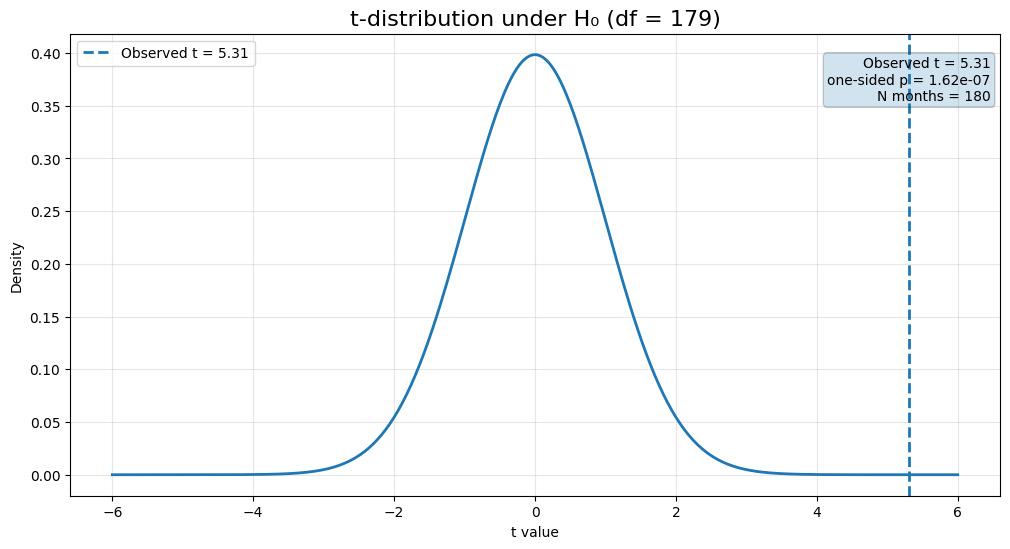

In [9]:
# Using same monthly_ret as above
df = backtest_results.copy()
df["month"] = df["date"].dt.to_period("M")
monthly_ret = df.groupby("month")["port_ret"].apply(lambda x: (1 + x).prod() - 1)
monthly_ret = monthly_ret.to_timestamp()

n = len(monthly_ret)
t_stat, p_two_sided = ttest_1samp(monthly_ret, popmean=0)
p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2

# t-distribution under H0 with df = n - 1
dfree = n - 1
x = np.linspace(-6, 6, 400)
pdf = student_t(df=dfree).pdf(x)

plt.figure(figsize=(12, 6))
plt.plot(x, pdf, linewidth=2)

# Vertical line for observed t-stat
plt.axvline(t_stat, linestyle="--", linewidth=2,
            label=f"Observed t = {t_stat:.2f}")

plt.title(f"t-distribution under H₀ (df = {dfree})", fontsize=16)
plt.xlabel("t value")
plt.ylabel("Density")

# Annotate p-value
text = (
    f"Observed t = {t_stat:.2f}\n"
    f"one-sided p = {p_one_sided:.2e}\n"
    f"N months = {n}"
)
plt.text(0.99, 0.95, text,
         transform=plt.gca().transAxes,
         ha="right", va="top",
         bbox=dict(boxstyle="round", alpha=0.2))

plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 2.2.2 Portfolio Visualisation

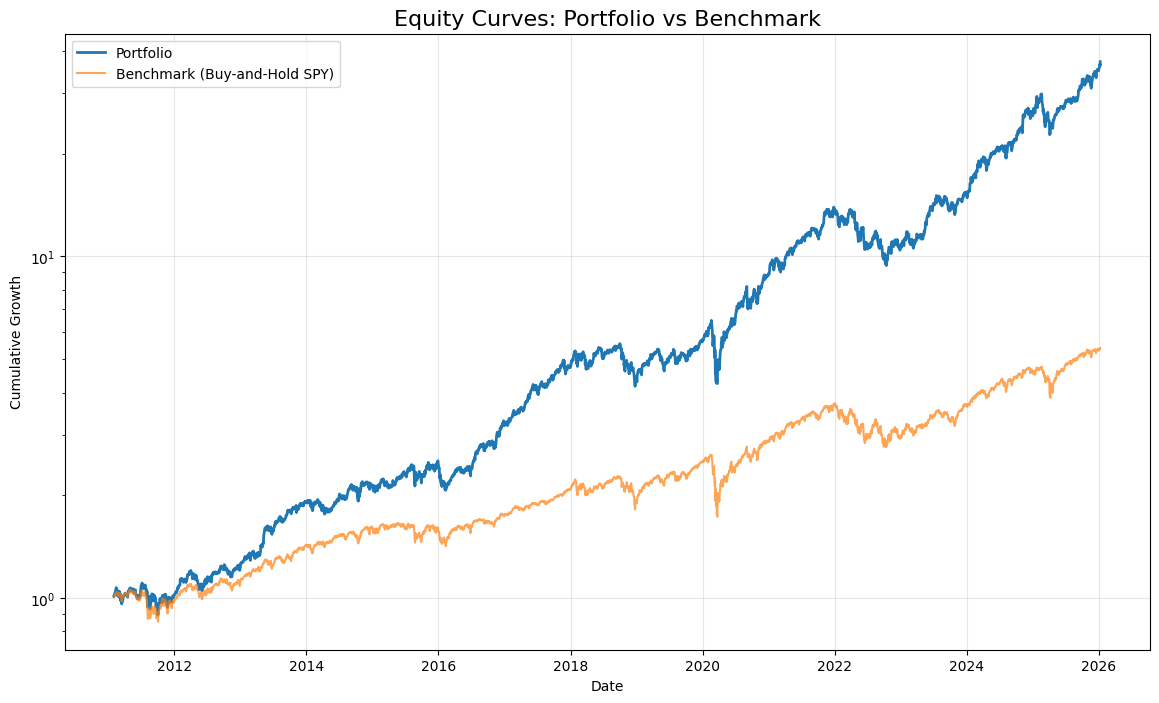

In [10]:
# === EQUITY CURVE VISUALIZATION ============================================
results = backtest_results.copy()

# Compute equity curves
results["port_equity"] = (1 + results["port_ret"]).cumprod()
results["bench_equity"] = (1 + results["bench_ret"]).cumprod()

plt.figure(figsize=(14, 8))
plt.plot(results["date"], results["port_equity"], label="Portfolio", linewidth=2)
plt.plot(results["date"], results["bench_equity"], label="Benchmark (Buy-and-Hold SPY)", alpha=0.7)

plt.title("Equity Curves: Portfolio vs Benchmark", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.yscale("log")  # log scale makes long-term comparison easier
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


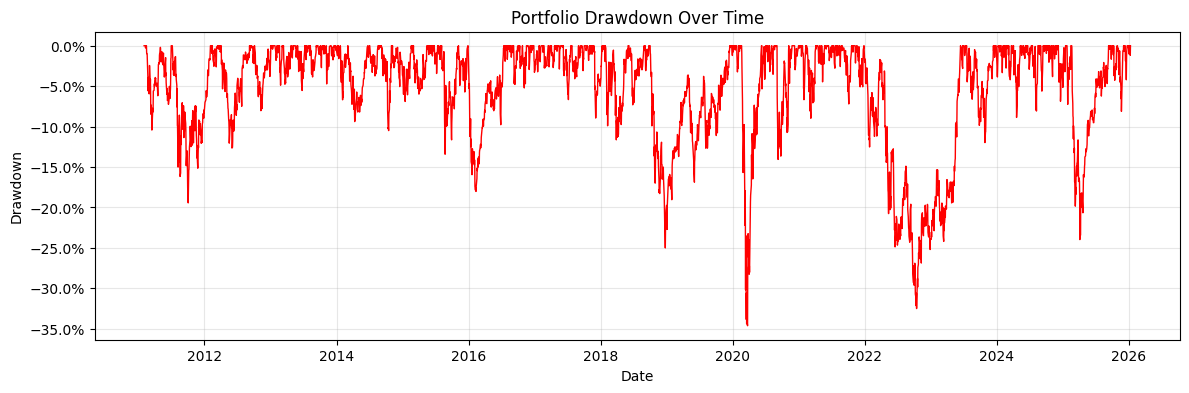

In [11]:
# Drawdown visualization
equity = results["port_equity"]
running_max = equity.cummax()
drawdown = equity / running_max - 1

plt.figure(figsize=(14, 4))
plt.plot(results["date"], drawdown, color="red", linewidth=1)
plt.title("Portfolio Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.show()


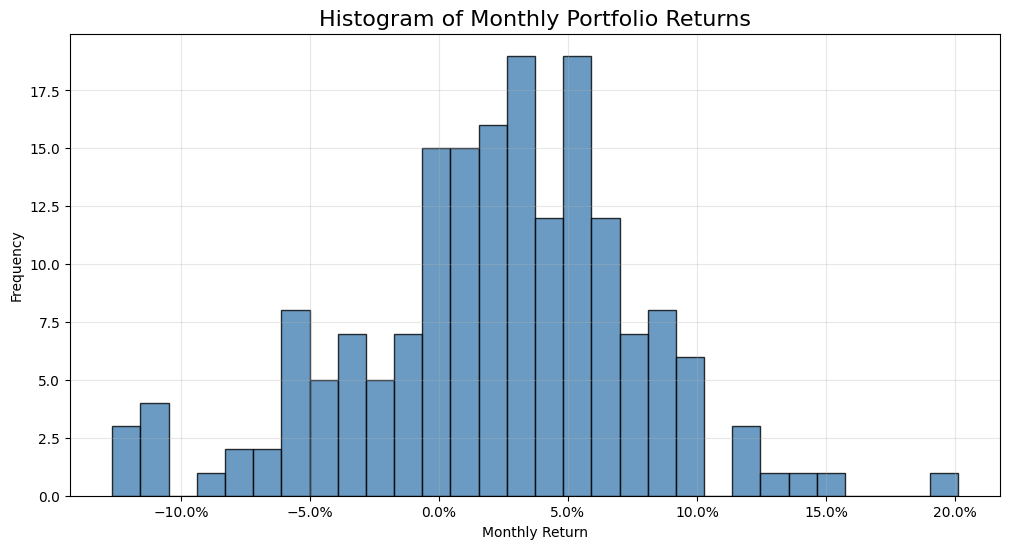

In [12]:
#returns histogram
# Copy results and compute month field
monthly = backtest_results.copy()
monthly["month"] = monthly["date"].dt.to_period("M")

# Compound daily returns → monthly returns
monthly_ret = (
    monthly.groupby("month")["port_ret"]
           .apply(lambda x: (1 + x).prod() - 1)
)

# Convert PeriodIndex to timestamp for plotting if needed
monthly_ret.index = monthly_ret.index.to_timestamp()

# === Plot histogram ===

plt.figure(figsize=(12, 6))
plt.hist(monthly_ret, bins=30, alpha=0.8, color="steelblue", edgecolor="black")

plt.title("Histogram of Monthly Portfolio Returns", fontsize=16)
plt.xlabel("Monthly Return")
plt.ylabel("Frequency")

# Format x-axis as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add grid
plt.grid(alpha=0.3)

plt.show()


### 2.2.3 Decile Spread Analysis

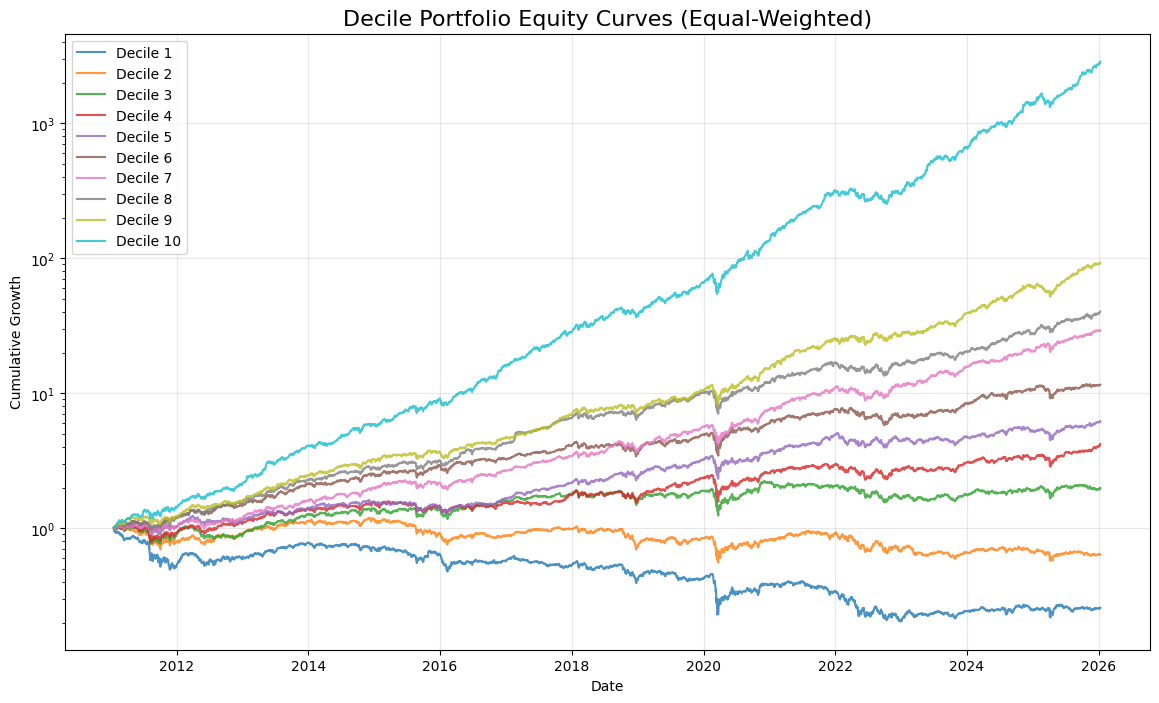

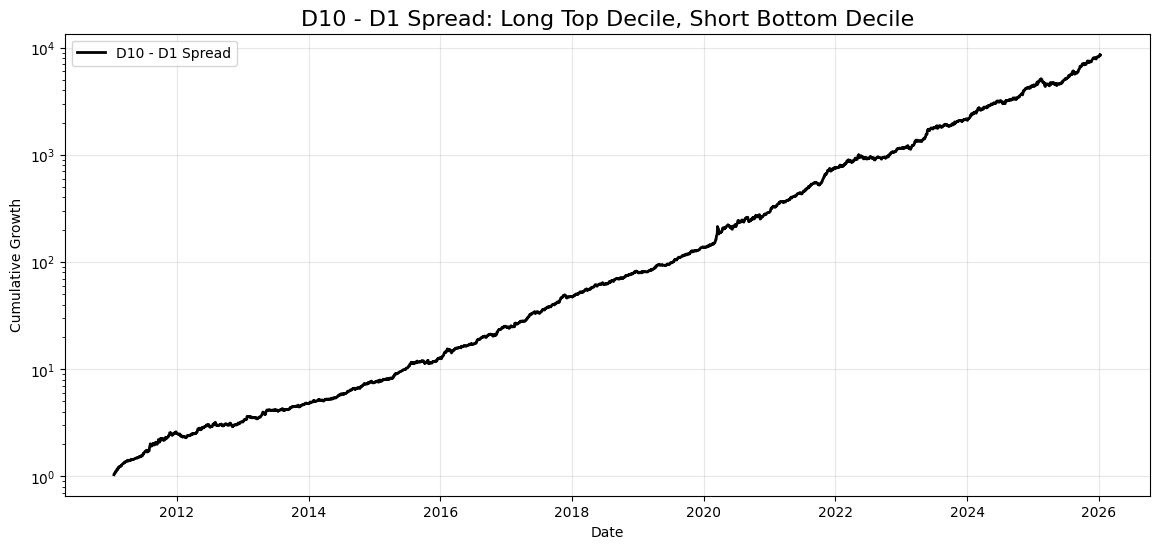


=== Annualized Decile Performance ===
alpha_decile         1         2         3         4         5         6  \
ann_return   -0.086821 -0.029715  0.046696  0.100326  0.129260  0.177902   
ann_vol       0.228062  0.199765  0.190990  0.185205  0.181970  0.183047   
sharpe       -0.380691 -0.148748  0.244495  0.541705  0.710337  0.971890   

alpha_decile         7         8         9        10  spread_D10_minus_D1  
ann_return    0.253216  0.280337  0.354130  0.702595             0.831854  
ann_vol       0.179619  0.182586  0.187741  0.215167             0.170183  
sharpe        1.409742  1.535372  1.886272  3.265341             4.887990  

=== Spread (D10 - D1) Annualized Stats ===
ann_return    0.831854
ann_vol       0.170183
sharpe        4.887990
dtype: float64


In [13]:
# === DECILE SPREAD ANALYSIS ================================================

# 1. Merge factors with daily returns for full cross-sectional panel
panel = pd.merge(
    prices_df, 
    factors_aligned[["date", "ticker", "alpha_decile"]],
    on=["date", "ticker"],
    how="inner"
)

# panel has: date, ticker, close, ret_1d, alpha_decile

# 2. Compute daily decile portfolio returns (equal-weight within each decile)
decile_returns = (
    panel
    .dropna(subset=["alpha_decile", "ret_1d"])
    .groupby(["date", "alpha_decile"])["ret_1d"]
    .mean()
    .unstack("alpha_decile")
    .sort_index()
)

# Ensure deciles 1–10 exist as columns
decile_returns = decile_returns.reindex(columns=range(1, 11))

# 3. Compute D10 – D1 daily return spread
decile_returns["spread_D10_minus_D1"] = decile_returns[10] - decile_returns[1]

# 4. Compute equity curves for each decile
decile_equity = (1 + decile_returns).cumprod()

# 5. Plot all decile equity curves
plt.figure(figsize=(14, 8))

for dec in range(1, 11):
    plt.plot(
        decile_equity.index, 
        decile_equity[dec], 
        label=f"Decile {dec}", 
        alpha=0.8
    )

plt.title("Decile Portfolio Equity Curves (Equal-Weighted)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 6. Plot decile spread equity curve
plt.figure(figsize=(14, 6))
plt.plot(
    decile_equity.index,
    decile_equity["spread_D10_minus_D1"],
    label="D10 - D1 Spread",
    linewidth=2,
    color="black"
)
plt.title("D10 - D1 Spread: Long Top Decile, Short Bottom Decile", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 7. Table of annualized performance per decile
def ann_stats(ret):
    r = ret.dropna()
    if len(r) == 0:
        return pd.Series({"ann_return": np.nan, "ann_vol": np.nan, "sharpe": np.nan})
    ann_return = (1 + r).prod() ** (252 / len(r)) - 1
    ann_vol = r.std(ddof=0) * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    return pd.Series({"ann_return": ann_return, "ann_vol": ann_vol, "sharpe": sharpe})

stats_table = decile_returns.apply(ann_stats)

print("\n=== Annualized Decile Performance ===")
print(stats_table)

# 8. Highlight the spread separately
spread_stats = ann_stats(decile_returns["spread_D10_minus_D1"])
print("\n=== Spread (D10 - D1) Annualized Stats ===")
print(spread_stats)


## Section 3: Monte Carlo Simulations

We ran 100,000 possible price paths through Monte Carlo simulations to better understand the strategy's variance. Represented in distributions, we computed the terminal value of the portfolio, maximum drawdown and duration spent in the maximum drawdown. We also computed the annualized Sharpe ratio.

=== Monte Carlo Summary (scenarios) ===
     scenario  n_paths  terminal_value_mean  terminal_value_median  \
0    base_all   100000         1.612105e+06           1.113653e+06   
1  worst_5pct     5000         1.949420e+05           2.041057e+05   
2   best_5pct     5000         6.992391e+06           6.025855e+06   

   total_return_mean  sharpe_mean  max_dd_mean  max_dd_duration_mean  \
0          52.736830     1.205316    -0.341160             546.94393   
1           5.498068     0.659670    -0.437469            1011.78380   
2         232.079699     1.753651    -0.276050             317.00240   

   win_rate_total_ret_gt_10pct  bankrupt_rate_below_5000  
0                      0.99999                       0.0  
1                      0.99999                       0.0  
2                      0.99999                       0.0  


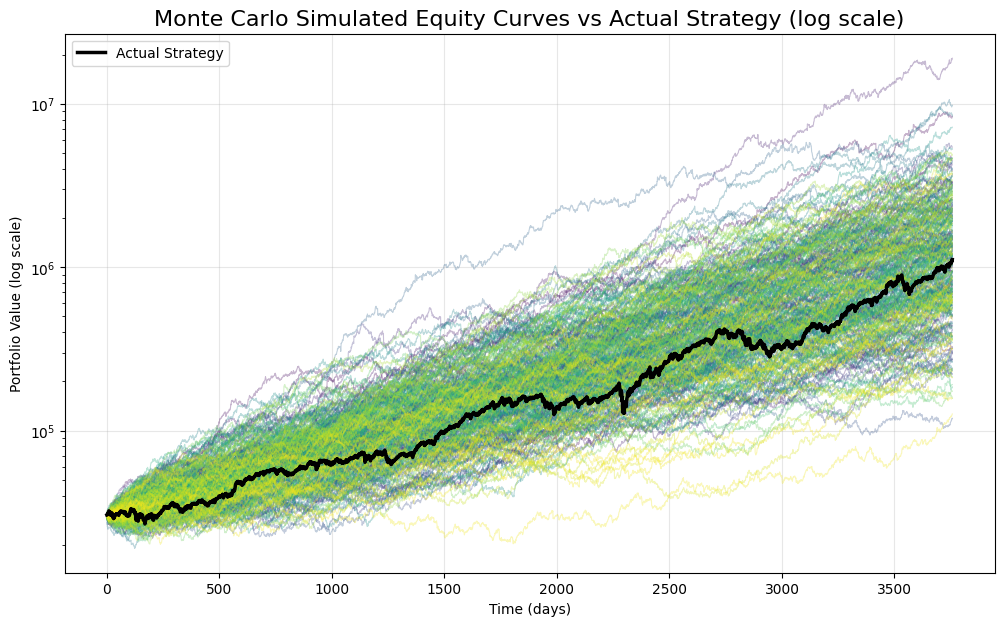

In [14]:
# === MONTE CARLO: BOOTSTRAP DAILY RETURNS ===============================
def monte_carlo_bootstrap_paths(
    daily_returns: pd.Series,
    n_paths: int = 100_000,
    initial_value: float = 30_000.0,
    random_state: int = 42,
    freq: int = 252,  # trading days per year
):
    """
    Bootstraps return paths with replacement starting from `initial_value`.

    Returns
    -------
    paths_df : DataFrame with per-path metrics:
        path_id, terminal_value, total_return, sharpe,
        max_drawdown, max_dd_duration, ever_below_5000
    stats_df : DataFrame summarizing:
        base (mean/median), worst 5%, best 5%, win_rate, bankrupt_rate
    """
    rng = np.random.default_rng(random_state)
    r = daily_returns.dropna().values
    T = len(r)

    terminal_values = []
    total_returns = []
    sharpe_list = []
    max_dd_list = []
    max_dd_dur_list = []
    ever_below_5000_list = []

    for _ in range(n_paths):
        # sample one full path of daily returns
        sample = rng.choice(r, size=T, replace=True)

        # equity curve starting from initial_value
        eq = initial_value * (1 + pd.Series(sample)).cumprod().values

        # terminal wealth & total return
        tw = eq[-1]
        tr = tw / initial_value - 1.0

        terminal_values.append(tw)
        total_returns.append(tr)

        # Sharpe
        if sample.std(ddof=0) > 0:
            shrp = (sample.mean() / sample.std(ddof=0)) * np.sqrt(freq)
        else:
            shrp = np.nan
        sharpe_list.append(shrp)

        # max drawdown (in % terms, negative number)
        running_max = np.maximum.accumulate(eq)
        dd_series = eq / running_max - 1.0
        max_dd = dd_series.min()
        max_dd_list.append(max_dd)

        # max drawdown duration (longest underwater streak in days)
        underwater = eq < running_max
        cur_len = 0
        max_len = 0
        for flag in underwater:
            if flag:
                cur_len += 1
                if cur_len > max_len:
                    max_len = cur_len
            else:
                cur_len = 0
        max_dd_dur_list.append(max_len)

        # ever "bankrupt": equity below 5,000 at any point
        ever_below_5000_list.append(eq.min() < 5_000.0)

    paths_df = pd.DataFrame({
        "path_id": np.arange(n_paths),
        "terminal_value": terminal_values,
        "total_return": total_returns,
        "sharpe": sharpe_list,
        "max_drawdown": max_dd_list,
        "max_dd_duration": max_dd_dur_list,
        "ever_below_5000": ever_below_5000_list,
    })

    # --- Aggregate statistics ---------------------------------------------

    # Base stats (mean/median)
    tv = paths_df["terminal_value"].values
    tr = paths_df["total_return"].values
    sh = paths_df["sharpe"].values
    dd = paths_df["max_drawdown"].values
    dd_dur = paths_df["max_dd_duration"].values
    ever_below = paths_df["ever_below_5000"].values

    win_rate = np.mean(tr > 0.10)          # > +10% total return
    bankrupt_rate = np.mean(ever_below)    # ever below 5,000

    # Worst / best 5% by total return
    q5 = np.quantile(tr, 0.05)
    q95 = np.quantile(tr, 0.95)

    worst_mask = tr <= q5
    best_mask = tr >= q95

    def summarize(mask, label):
        """Helper to build a scenario row."""
        if mask.sum() == 0:
            return {
                "scenario": label,
                "n_paths": 0,
                "terminal_value_mean": np.nan,
                "terminal_value_median": np.nan,
                "total_return_mean": np.nan,
                "sharpe_mean": np.nan,
                "max_dd_mean": np.nan,
                "max_dd_duration_mean": np.nan,
            }
        return {
            "scenario": label,
            "n_paths": int(mask.sum()),
            "terminal_value_mean": float(tv[mask].mean()),
            "terminal_value_median": float(np.median(tv[mask])),
            "total_return_mean": float(tr[mask].mean()),
            "sharpe_mean": float(np.nanmean(sh[mask])),
            "max_dd_mean": float(dd[mask].mean()),
            "max_dd_duration_mean": float(dd_dur[mask].mean()),
        }

    rows = []
    # Base case: whole distribution
    rows.append({
        "scenario": "base_all",
        "n_paths": int(len(tv)),
        "terminal_value_mean": float(tv.mean()),
        "terminal_value_median": float(np.median(tv)),
        "total_return_mean": float(tr.mean()),
        "sharpe_mean": float(np.nanmean(sh)),
        "max_dd_mean": float(dd.mean()),
        "max_dd_duration_mean": float(dd_dur.mean()),
    })
    # Worst 5%
    rows.append(summarize(worst_mask, "worst_5pct"))
    # Best 5%
    rows.append(summarize(best_mask, "best_5pct"))

    stats_df = pd.DataFrame(rows)

    # Add global win / bankrupt rates as separate columns
    stats_df["win_rate_total_ret_gt_10pct"] = win_rate
    stats_df["bankrupt_rate_below_5000"] = bankrupt_rate

    return paths_df, stats_df


# Run Monte Carlo with 100,000 paths
paths_df, mc_stats = monte_carlo_bootstrap_paths(
    backtest_results["port_ret"],
    n_paths=100_000,
    initial_value=30_000.0,
)

print("=== Monte Carlo Summary (scenarios) ===")
print(mc_stats)

# === MONTE CARLO EQUITY CURVE SPAGHETTI PLOT ==============================

initial_value = 30_000.0
r = backtest_results["port_ret"].dropna().values
T = len(r)

n_plot_paths = 300
rng = np.random.default_rng(123)

equity_paths = []

for _ in range(n_plot_paths):
    sample = rng.choice(r, size=T, replace=True)
    eq = initial_value * (1 + pd.Series(sample)).cumprod().values
    equity_paths.append(eq)

equity_paths = np.array(equity_paths)

# Actual equity curve from backtest
actual_equity = initial_value * (1 + backtest_results["port_ret"].dropna()).cumprod().values

plt.figure(figsize=(12, 7))

# Plot simulated paths with a colormap
for i in range(n_plot_paths):
    plt.plot(equity_paths[i], color=plt.cm.viridis(i / n_plot_paths), alpha=0.3, linewidth=0.8)

# Overlay actual strategy in bold
plt.plot(actual_equity, color="black", linewidth=2.5, label="Actual Strategy")

plt.yscale("log")
plt.title("Monte Carlo Simulated Equity Curves vs Actual Strategy (log scale)", fontsize=16)
plt.xlabel("Time (days)")
plt.ylabel("Portfolio Value (log scale)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 3.1 Terminal Portfolio Value Results

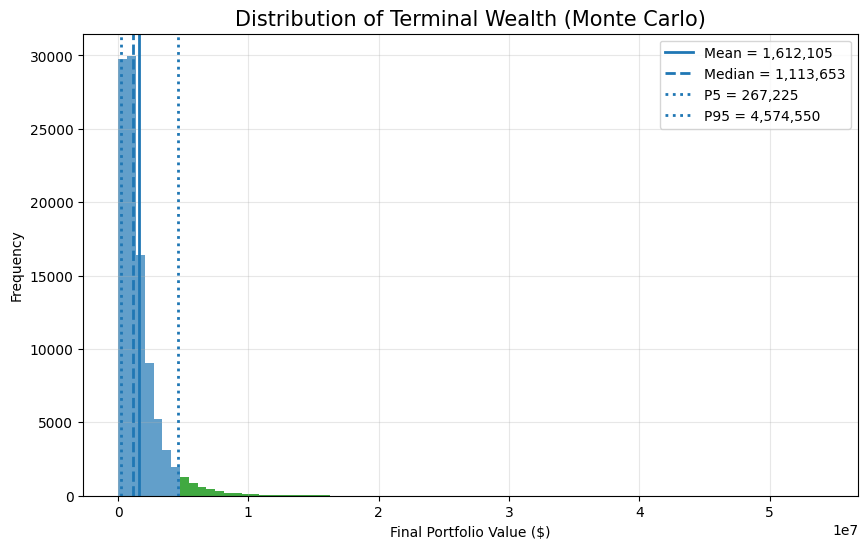

In [15]:
vals = paths_df["terminal_value"].dropna()

mean_tv = vals.mean()
median_tv = vals.median()
p5_tv = vals.quantile(0.05)
p95_tv = vals.quantile(0.95)

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(vals, bins=80, alpha=0.7)

# Shade worst 5% (left tail) and best 5% (right tail)
for left, right, patch in zip(bins[:-1], bins[1:], patches):
    mid = 0.5 * (left + right)
    if mid <= p5_tv:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:red")   # worst 5%
    elif mid >= p95_tv:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:green") # best 5%

# Vertical lines for mean, median, p05, p95
plt.axvline(mean_tv, linestyle="-", linewidth=2, label=f"Mean = {mean_tv:,.0f}")
plt.axvline(median_tv, linestyle="--", linewidth=2, label=f"Median = {median_tv:,.0f}")
plt.axvline(p5_tv, linestyle=":", linewidth=2, label=f"P5 = {p5_tv:,.0f}")
plt.axvline(p95_tv, linestyle=":", linewidth=2, label=f"P95 = {p95_tv:,.0f}")

plt.title("Distribution of Terminal Wealth (Monte Carlo)", fontsize=15)
plt.xlabel("Final Portfolio Value ($)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### 4.2 Drawdown Analysis Results

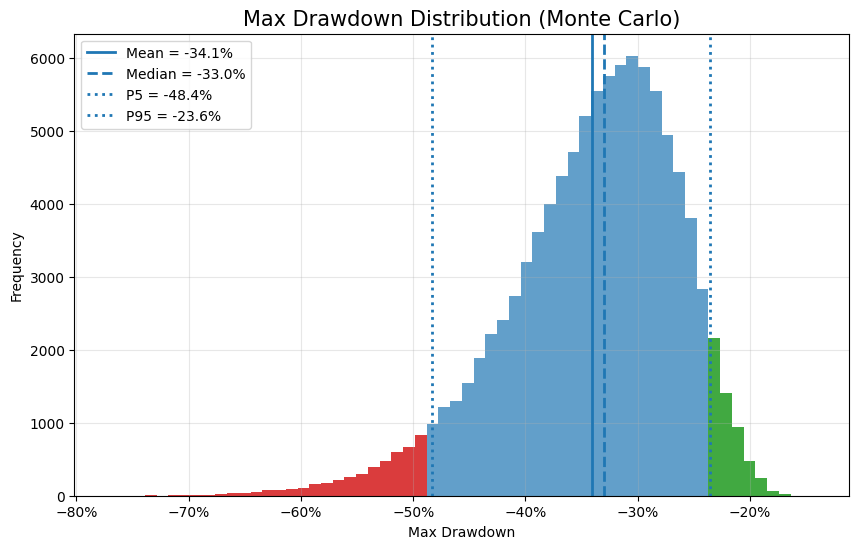

In [16]:
dd_vals = paths_df["max_drawdown"].dropna()

mean_dd = dd_vals.mean()
median_dd = dd_vals.median()
p5_dd = dd_vals.quantile(0.05)
p95_dd = dd_vals.quantile(0.95)

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(dd_vals, bins=60, alpha=0.7)

# Shade worst 5% drawdowns (more negative) and best 5% (least negative)
for left, right, patch in zip(bins[:-1], bins[1:], patches):
    mid = 0.5 * (left + right)
    if mid <= p5_dd:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:red")   # worst 5% DD (deepest)
    elif mid >= p95_dd:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:green") # best 5% DD (shallowest)

plt.axvline(mean_dd, linestyle="-", linewidth=2, label=f"Mean = {mean_dd:.1%}")
plt.axvline(median_dd, linestyle="--", linewidth=2, label=f"Median = {median_dd:.1%}")
plt.axvline(p5_dd, linestyle=":", linewidth=2, label=f"P5 = {p5_dd:.1%}")
plt.axvline(p95_dd, linestyle=":", linewidth=2, label=f"P95 = {p95_dd:.1%}")

plt.title("Max Drawdown Distribution (Monte Carlo)", fontsize=15)
plt.xlabel("Max Drawdown")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

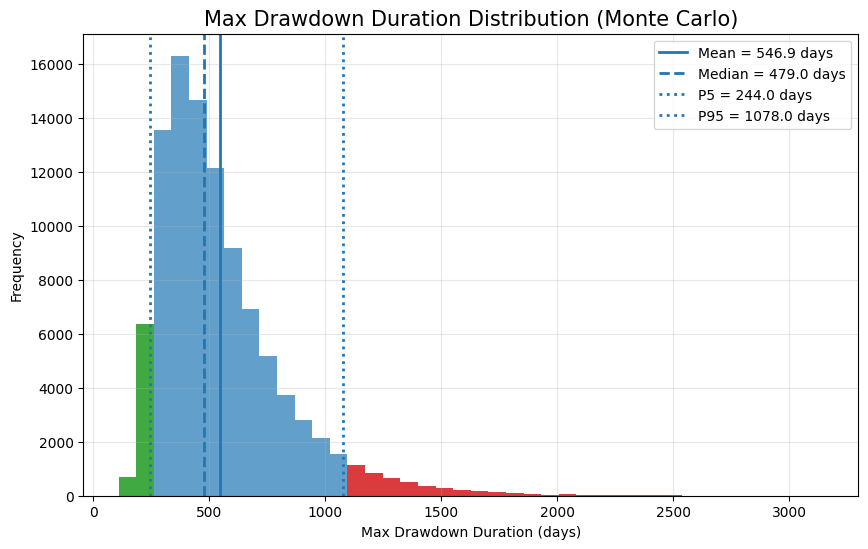

In [17]:
dd_dur_vals = paths_df["max_dd_duration"].dropna()

mean_dur = dd_dur_vals.mean()
median_dur = dd_dur_vals.median()
p5_dur = dd_dur_vals.quantile(0.05)
p95_dur = dd_dur_vals.quantile(0.95)

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(dd_dur_vals, bins=40, alpha=0.7)

for left, right, patch in zip(bins[:-1], bins[1:], patches):
    mid = 0.5 * (left + right)
    if mid <= p5_dur:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:green")  # shortest 5% underwater periods
    elif mid >= p95_dur:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:red")    # longest 5% underwater periods

plt.axvline(mean_dur, linestyle="-", linewidth=2,
            label=f"Mean = {mean_dur:.1f} days")
plt.axvline(median_dur, linestyle="--", linewidth=2,
            label=f"Median = {median_dur:.1f} days")
plt.axvline(p5_dur, linestyle=":", linewidth=2,
            label=f"P5 = {p5_dur:.1f} days")
plt.axvline(p95_dur, linestyle=":", linewidth=2,
            label=f"P95 = {p95_dur:.1f} days")

plt.title("Max Drawdown Duration Distribution (Monte Carlo)", fontsize=15)
plt.xlabel("Max Drawdown Duration (days)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 4.3 Annualized Sharpe Ratio Analysis

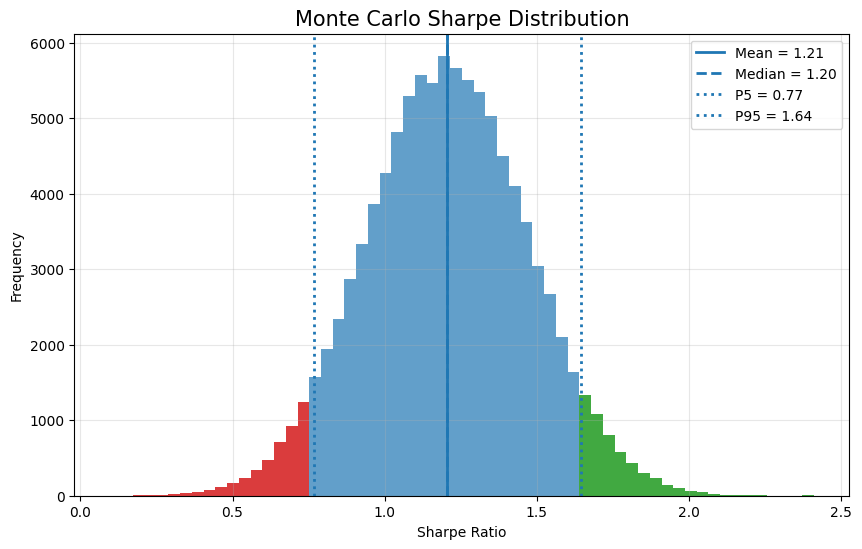

In [18]:
sh_vals = paths_df["sharpe"].dropna()

mean_sh = sh_vals.mean()
median_sh = sh_vals.median()
p5_sh = sh_vals.quantile(0.05)
p95_sh = sh_vals.quantile(0.95)

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(sh_vals, bins=60, alpha=0.7)

for left, right, patch in zip(bins[:-1], bins[1:], patches):
    mid = 0.5 * (left + right)
    if mid <= p5_sh:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:red")   # worst 5% Sharpe
    elif mid >= p95_sh:
        patch.set_alpha(0.9)
        patch.set_facecolor("tab:green") # best 5% Sharpe

plt.axvline(mean_sh, linestyle="-", linewidth=2, label=f"Mean = {mean_sh:.2f}")
plt.axvline(median_sh, linestyle="--", linewidth=2, label=f"Median = {median_sh:.2f}")
plt.axvline(p5_sh, linestyle=":", linewidth=2, label=f"P5 = {p5_sh:.2f}")
plt.axvline(p95_sh, linestyle=":", linewidth=2, label=f"P95 = {p95_sh:.2f}")

plt.title("Monte Carlo Sharpe Distribution", fontsize=15)
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Section 4: Alternatives

## 4.1 Dynamic Weighting with VIX

We also experimented with dynamic weighting; literature review indicates that Momentum outperforms in times of stress, while Value and Quality perform better in normal, calm financial scenarios. We put this hypothesis to the test using VIX as an indicator of financial instability in the markets.

In [19]:
# === 1. BUILD factors_vix WITH VIX REGIMES & DYNAMIC ALPHA ==============
from ib_insync import Index

def fetch_vix_ibkr(
    host: str = "127.0.0.1",
    port: int = 7496,
    clientId: int = 5,
    durationStr: str = "15 Y",
    barSizeSetting: str = "1 day",
    whatToShow: str = "TRADES",
    useRTH: bool = False,
) -> pd.DataFrame:
    """
    Fetch daily VIX history from IBKR as an Index (CBOE / CBOEIND).

    Returns DataFrame with columns:
        ['date', 'vix']

    If nothing is pulled, returns an empty DataFrame.
    """
    ib = IB()
    ib.connect(host, port, clientId=clientId)

    bars = None
    for ex in ["CBOE", "CBOEIND"]:
        try:
            vix_contract = Index("VIX", ex, "USD")
            bars = ib.reqHistoricalData(
                vix_contract,
                endDateTime="",
                durationStr=durationStr,
                barSizeSetting=barSizeSetting,
                whatToShow=whatToShow,
                useRTH=useRTH,
                formatDate=1,
            )
            if bars:
                break
        except Exception as e:
            print(f"Failed on exchange={ex}: {e}")

    ib.disconnect()

    if not bars:
        print("WARNING: No VIX data pulled from IBKR. Returning empty DataFrame.")
        return pd.DataFrame(columns=["date", "vix"])

    df_vix = util.df(bars)[["date", "close"]].rename(columns={"close": "vix"})
    df_vix["date"] = pd.to_datetime(df_vix["date"])
    df_vix = df_vix.sort_values("date").reset_index(drop=True)
    return df_vix


# 1) Fetch VIX
df_vix = fetch_vix_ibkr()

start_date = factors_aligned["date"].min()
end_date   = factors_aligned["date"].max()

# Restrict VIX to factor backtest window
df_vix = df_vix[(df_vix["date"] >= start_date) & (df_vix["date"] <= end_date)].copy()

if df_vix.empty:
    # ---- Fallback: no VIX data available ----
    print("No VIX data available from IBKR. Using static 'medium' regime for all dates.")

    factors_vix = factors_aligned.copy()
    factors_vix["vix"] = np.nan
    factors_vix["vix_regime"] = "medium"  # treat everything as 'medium' regime

    # Medium regime weights = equal weights
    w = {"value": 1/3, "quality": 1/3, "momentum": 1/3}
    factors_vix["alpha_score_dyn"] = (
        w["value"]    * factors_vix["value_score"] +
        w["quality"]  * factors_vix["quality_score"] +
        w["momentum"] * factors_vix["momentum_score"]
    )

else:
    # ---- Normal path: we have VIX data ----
    factors_vix = (
        factors_aligned
        .merge(df_vix, on="date", how="left")
        .sort_values(["date", "ticker"])
        .reset_index(drop=True)
    )

    # Forward-fill VIX for missing trading days
    factors_vix["vix"] = factors_vix["vix"].ffill()

    # 2) Classify VIX regime
    def classify_vix(v):
        if v < 15:
            return "low"
        elif v < 25:
            return "medium"
        else:
            return "high"

    factors_vix["vix_regime"] = factors_vix["vix"].apply(classify_vix)

    # 3) Regime-specific weights
    regime_weights = {
        "low":    {"value": 0.7,  "quality": 0.2,  "momentum": 0.1},
        "medium": {"value": 1/3,  "quality": 1/3,  "momentum": 1/3},
        "high":   {"value": 0.1,  "quality": 0.2,  "momentum": 0.7},
    }

    # 4) Compute dynamic alpha score row-wise
    def compute_dynamic_alpha(row):
        w = regime_weights[row["vix_regime"]]
        return (
            w["value"]    * row["value_score"]
            + w["quality"]  * row["quality_score"]
            + w["momentum"] * row["momentum_score"]
        )

    factors_vix["alpha_score_dyn"] = factors_vix.apply(compute_dynamic_alpha, axis=1)

# 5) Dynamic deciles (runs in both branches)
def decile_rank(s, n=10):
    r = s.rank(method="first")
    return pd.qcut(r, q=n, labels=False, duplicates="drop") + 1

factors_vix["alpha_decile_dyn"] = (
    factors_vix
    .groupby("date")["alpha_score_dyn"]
    .transform(decile_rank)
)

print("factors_vix preview:")
print(
    factors_vix[["date", "ticker", "vix", "vix_regime",
                 "value_score", "quality_score", "momentum_score",
                 "alpha_score_dyn", "alpha_decile_dyn"]]
    .head()
)

# === REGIME FREQUENCY ANALYSIS (MONTHLY) ================================

# Evaluate regimes on rebalance dates only
rebal_df = (
    factors_vix[factors_vix["date"].isin(rebal_dates)][["date", "vix_regime"]]
    .drop_duplicates(subset=["date"])
)

regime_pct = (rebal_df["vix_regime"].value_counts(normalize=True) * 100).round(2)

print("=== VIX Regime Frequency (Monthly, Based on Rebalance Dates) ===")
print(regime_pct)

factors_vix preview:
        date ticker    vix vix_regime  value_score  quality_score  \
0 2011-01-14   AAPL  15.39     medium     0.148533      -0.287378   
1 2011-01-14    ABT  15.39     medium    -0.327837      -0.145813   
2 2011-01-14    ACN  15.39     medium     0.220881      -1.550390   
3 2011-01-14   ADBE  15.39     medium     0.567761       0.859318   
4 2011-01-14    ADP  15.39     medium     0.238071      -0.322003   

   momentum_score  alpha_score_dyn  alpha_decile_dyn  
0             NaN              NaN               NaN  
1             NaN              NaN               NaN  
2             NaN              NaN               NaN  
3             NaN              NaN               NaN  
4             NaN              NaN               NaN  
=== VIX Regime Frequency (Monthly, Based on Rebalance Dates) ===
vix_regime
medium    51.93
low       34.25
high      13.81
Name: proportion, dtype: float64


C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2508839899.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2508839899.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
C:\Users\Jia Wei\AppData\Local\Temp\ipykernel_34740\2508839899.py:63

Static backtest head:
        date  port_ret  bench_ret
0 2011-02-01  0.013182   0.015069
1 2011-02-02  0.000541  -0.001597
2 2011-02-03  0.001945   0.001543
3 2011-02-04  0.012336   0.003634
4 2011-02-07  0.008786   0.004287

Dynamic backtest head:
        date  port_ret  bench_ret
0 2011-02-01  0.013182   0.015069
1 2011-02-02  0.000541  -0.001597
2 2011-02-03  0.001945   0.001543
3 2011-02-04  0.012336   0.003634
4 2011-02-07  0.008786   0.004287

=== Static vs Dynamic Portfolio Metrics (Historical) ===
                        static    dynamic
total_pnl            36.111404  32.742282
excess_pnl_vs_bench  25.208717  21.839595
ann_return            0.274226   0.266120
ann_vol               0.222008   0.215490
sharpe                1.203603   1.203629
max_drawdown         -0.346368  -0.297579
tail_pnl_1pct        -0.039061  -0.038566
var_95                0.021313   0.020402
win_rate_monthly      0.705556   0.688889


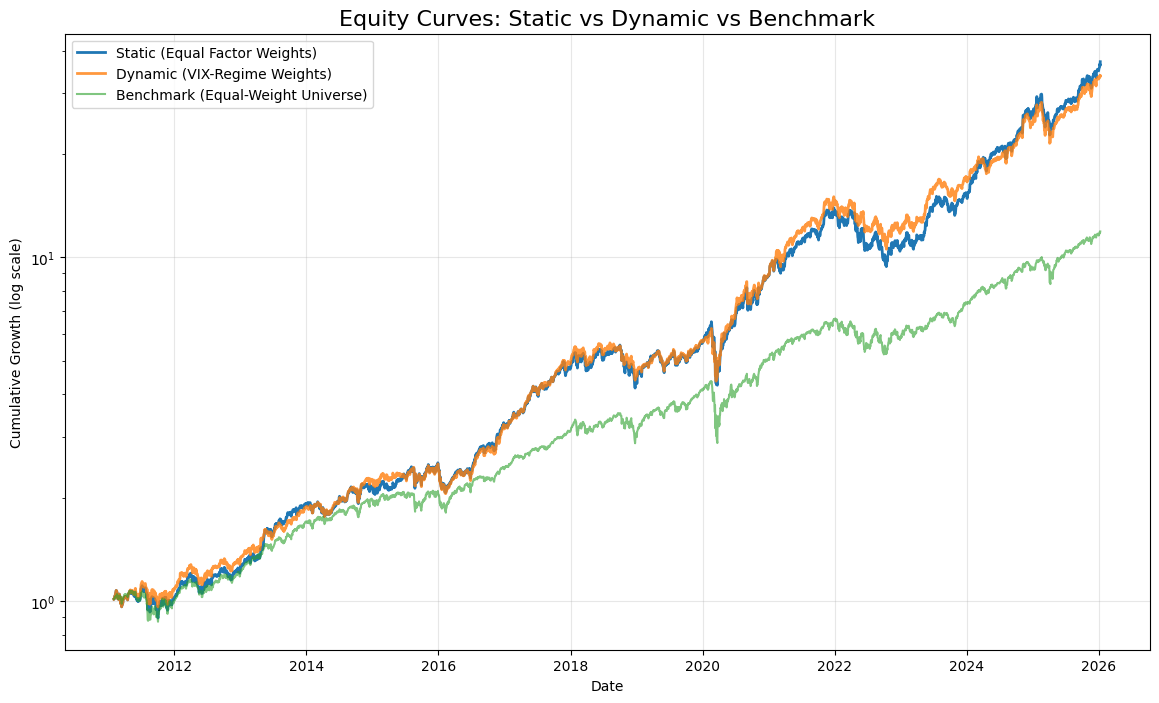


=== Monte Carlo Summary (Static) ===
                        0
terminal_mean   53.387532
terminal_p5      9.289836
terminal_p50    38.729103
terminal_p95   148.283672
sharpe_mean      1.208128
sharpe_p5        0.773090
sharpe_p95       1.637257
dd_mean         -0.341417
dd_p5           -0.478644
dd_p95          -0.237876

=== Monte Carlo Summary (Dynamic) ===
                        0
terminal_mean   48.122877
terminal_p5      8.018770
terminal_p50    33.793402
terminal_p95   132.076157
sharpe_mean      1.206108
sharpe_p5        0.756572
sharpe_p95       1.647589
dd_mean         -0.330588
dd_p5           -0.466851
dd_p95          -0.229511


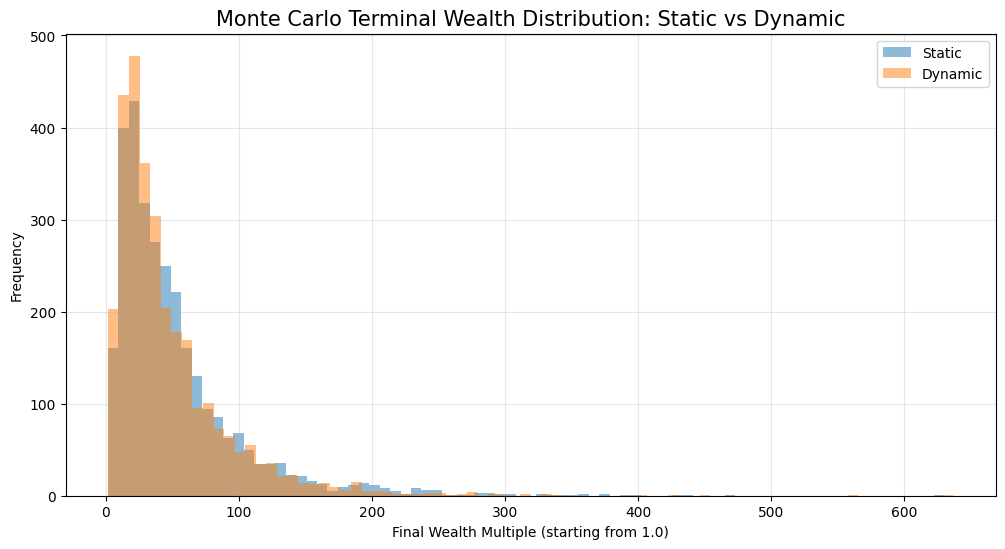

In [20]:
# === STATIC vs DYNAMIC FACTOR WEIGHTING: BACKTEST + MONTE CARLO ==========

# -------------------------------------------------------------------------
# 1. Backtest function: long-only, equal-weight, top-decile strategy
# -------------------------------------------------------------------------
def run_long_top_decile_backtest(
    factors: pd.DataFrame,
    prices: pd.DataFrame,
    rebal_dates: list,
    top_decile: int = 10,
    decile_col: str = "alpha_decile",
) -> pd.DataFrame:
    """
    Long-only, equal-weight, top-decile strategy.
    Rebalance monthly on rebal_dates.

    decile_col: which decile column to use ("alpha_decile" or "alpha_decile_dyn")

    Returns DataFrame with:
        date, port_ret, bench_ret
    where bench_ret is equal-weight daily universe return.
    """
    prices_sorted = prices.sort_values(["date", "ticker"])

    # Equal-weight benchmark across all tickers each day
    bench_ret = (
        prices_sorted
        .groupby("date")["ret_1d"]
        .mean()
        .rename("bench_ret")
        .reset_index()
    )

    port_ret_records = []

    for i in range(len(rebal_dates) - 1):
        reb_date = rebal_dates[i]
        next_reb_date = rebal_dates[i + 1]

        # Factor snapshot on rebalance date
        f_slice = factors[factors["date"] == reb_date].copy()

        # Select top decile names
        long_names = f_slice.loc[f_slice[decile_col] == top_decile, "ticker"].unique()
        if len(long_names) == 0:
            continue

        # Equal weights
        w = 1.0 / len(long_names)

        # Price slice between (reb_date, next_reb_date]
        mask_period = (prices["date"] > reb_date) & (prices["date"] <= next_reb_date)
        p_slice = prices.loc[mask_period & prices["ticker"].isin(long_names)].copy()
        if p_slice.empty:
            continue

        p_slice["weight"] = w

        # Daily portfolio returns
        daily_port = (
            p_slice
            .groupby("date")
            .apply(lambda df: (df["weight"] * df["ret_1d"]).sum())
            .rename("port_ret")
            .reset_index()
        )

        port_ret_records.append(daily_port)

    if not port_ret_records:
        return pd.DataFrame(columns=["date", "port_ret", "bench_ret"])

    port_ret_df = pd.concat(port_ret_records, ignore_index=True)

    # Align with benchmark
    results = pd.merge(port_ret_df, bench_ret, on="date", how="inner")
    results = results.sort_values("date").reset_index(drop=True)
    return results


# -------------------------------------------------------------------------
# 2. Run backtests: static vs dynamic weighting
# -------------------------------------------------------------------------
# Static strategy (flat factor weights)
backtest_static = run_long_top_decile_backtest(
    factors=factors_aligned,
    prices=prices_df,
    rebal_dates=rebal_dates,
    top_decile=10,
    decile_col="alpha_decile",
)

# Dynamic strategy (VIX-regime-weighted factors)
backtest_dynamic = run_long_top_decile_backtest(
    factors=factors_vix,
    prices=prices_df,
    rebal_dates=rebal_dates,
    top_decile=10,
    decile_col="alpha_decile_dyn",
)

print("Static backtest head:")
print(backtest_static.head())
print("\nDynamic backtest head:")
print(backtest_dynamic.head())

# -------------------------------------------------------------------------
# 3. Side-by-side metrics comparison (historical backtest)
# -------------------------------------------------------------------------
metrics_static = compute_portfolio_metrics(backtest_static)
metrics_dynamic = compute_portfolio_metrics(backtest_dynamic)

comparison = pd.concat(
    [
        metrics_static.T.rename(columns={0: "static"}),
        metrics_dynamic.T.rename(columns={0: "dynamic"}),
    ],
    axis=1,
)

print("\n=== Static vs Dynamic Portfolio Metrics (Historical) ===")
print(comparison)

# -------------------------------------------------------------------------
# 4. Equity curves: static vs dynamic vs benchmark
# -------------------------------------------------------------------------
merged = (
    backtest_static[["date", "port_ret", "bench_ret"]]
    .merge(
        backtest_dynamic[["date", "port_ret"]],
        on="date",
        how="inner",
        suffixes=("_static", "_dynamic"),
    )
)

merged["port_equity_static"] = (1 + merged["port_ret_static"]).cumprod()
merged["port_equity_dynamic"] = (1 + merged["port_ret_dynamic"]).cumprod()
merged["bench_equity"] = (1 + merged["bench_ret"]).cumprod()

plt.figure(figsize=(14, 8))
plt.plot(
    merged["date"],
    merged["port_equity_static"],
    label="Static (Equal Factor Weights)",
    linewidth=2,
)
plt.plot(
    merged["date"],
    merged["port_equity_dynamic"],
    label="Dynamic (VIX-Regime Weights)",
    linewidth=2,
    alpha=0.8,
)
plt.plot(
    merged["date"],
    merged["bench_equity"],
    label="Benchmark (Equal-Weight Universe)",
    alpha=0.6,
)

plt.yscale("log")
plt.title("Equity Curves: Static vs Dynamic vs Benchmark", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# -------------------------------------------------------------------------
# 5. Monte Carlo: static vs dynamic (future simulation)
# -------------------------------------------------------------------------
def monte_carlo_bootstrap_paths(
    daily_returns: pd.Series,
    n_paths: int = 5000,
    random_state: int = 42,
    freq: int = 252,
):
    """
    Bootstrap daily returns with replacement to generate synthetic paths.
    Returns:
        paths_df: per-path terminal_value, sharpe, max_drawdown
        stats_df: summary stats across paths
    """
    rng = np.random.default_rng(random_state)
    r = daily_returns.dropna().values
    T = len(r)

    terminal_values = []
    sharpe_list = []
    max_dd_list = []

    for _ in range(n_paths):
        sample = rng.choice(r, size=T, replace=True)

        # Terminal wealth (starting from 1.0)
        tw = np.prod(1 + sample)
        terminal_values.append(tw)

        # Sharpe
        if sample.std(ddof=0) > 0:
            shrp = (sample.mean() / sample.std(ddof=0)) * np.sqrt(freq)
        else:
            shrp = np.nan
        sharpe_list.append(shrp)

        # Max drawdown
        eq = (1 + pd.Series(sample)).cumprod()
        running_max = eq.cummax()
        dd = (eq / running_max - 1).min()
        max_dd_list.append(dd)

    paths_df = pd.DataFrame({
        "terminal_value": terminal_values,
        "sharpe": sharpe_list,
        "max_drawdown": max_dd_list,
    })

    stats_df = pd.DataFrame({
        "terminal_mean": [paths_df["terminal_value"].mean()],
        "terminal_p5":   [paths_df["terminal_value"].quantile(0.05)],
        "terminal_p50":  [paths_df["terminal_value"].quantile(0.50)],
        "terminal_p95":  [paths_df["terminal_value"].quantile(0.95)],
        "sharpe_mean":   [paths_df["sharpe"].mean()],
        "sharpe_p5":     [paths_df["sharpe"].quantile(0.05)],
        "sharpe_p95":    [paths_df["sharpe"].quantile(0.95)],
        "dd_mean":       [paths_df["max_drawdown"].mean()],
        "dd_p5":         [paths_df["max_drawdown"].quantile(0.05)],
        "dd_p95":        [paths_df["max_drawdown"].quantile(0.95)],
    })

    return paths_df, stats_df

# Static strategy Monte Carlo
paths_static, mc_static = monte_carlo_bootstrap_paths(
    backtest_static["port_ret"],
    n_paths=3000,
    random_state=1,
)

# Dynamic strategy Monte Carlo
paths_dynamic, mc_dynamic = monte_carlo_bootstrap_paths(
    backtest_dynamic["port_ret"],
    n_paths=3000,
    random_state=2,
)

print("\n=== Monte Carlo Summary (Static) ===")
print(mc_static.T)
print("\n=== Monte Carlo Summary (Dynamic) ===")
print(mc_dynamic.T)

# -------------------------------------------------------------------------
# 6. Monte Carlo terminal wealth comparison: static vs dynamic
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.hist(
    paths_static["terminal_value"],
    bins=80,
    alpha=0.5,
    label="Static",
)
plt.hist(
    paths_dynamic["terminal_value"],
    bins=80,
    alpha=0.5,
    label="Dynamic",
)
plt.title("Monte Carlo Terminal Wealth Distribution: Static vs Dynamic", fontsize=15)
plt.xlabel("Final Wealth Multiple (starting from 1.0)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Section 5: Conclusion

In [21]:
# === CURRENT HOLDINGS AS OF LAST REBALANCE DATE =========================

# 1) Figure out which rebalance date is the last one actually used
if backtest_results.empty:
    print("Backtest results are empty; cannot compute current holdings.")
else:
    backtest_end = backtest_results["date"].max()

    # Last rebalance date that is <= last backtest date
    last_reb_date = max([d for d in rebal_dates if d <= backtest_end])

    print(f"\n📌 Latest rebalance date used in backtest: {last_reb_date.date()}")

    # 2) Slice factor table at that rebalance date
    f_slice = factors_aligned[factors_aligned["date"] == last_reb_date].copy()

    # Top decile names (same rule as backtest: alpha_decile == 10)
    current_names = f_slice.loc[f_slice["alpha_decile"] == 10, "ticker"].unique()

    if len(current_names) == 0:
        print("No names in top decile on the last rebalance date.")
    else:
        # Equal weights
        w = 1.0 / len(current_names)

        # Optional: bring in scores (and sector if available) for display
        cols_to_show = ["ticker", "alpha_decile", "alpha_score",
                        "value_score", "quality_score", "momentum_score"]
        if "sector" in f_slice.columns:
            cols_to_show.insert(1, "sector")

        holdings = (
            f_slice[f_slice["ticker"].isin(current_names)]
            .sort_values("alpha_score", ascending=False)
            .loc[:, cols_to_show]
            .drop_duplicates(subset=["ticker"])
            .reset_index(drop=True)
        )

        holdings["weight"] = w

        print("\n=== CURRENT MODEL PORTFOLIO (TOP DECILE LONG-ONLY) ===")
        print(f"As of rebalance date: {last_reb_date.date()}")
        print(f"Number of names: {len(holdings)}\n")
        print(holdings)



📌 Latest rebalance date used in backtest: 2026-01-09

=== CURRENT MODEL PORTFOLIO (TOP DECILE LONG-ONLY) ===
As of rebalance date: 2026-01-09
Number of names: 10

  ticker              sector  alpha_decile  alpha_score  value_score  \
0   NVDA          Technology          10.0     1.924081    -0.193238   
1     MU          Technology          10.0     0.689825     0.129222   
2   INTC          Technology          10.0     0.611515     1.882613   
3   AMAT          Technology          10.0     0.551528     0.147329   
4      V  Financial Services          10.0     0.469759     0.558029   
5    JNJ          Healthcare          10.0     0.406727     0.271037   
6    MRK          Healthcare          10.0     0.402900     0.118585   
7    UNP         Industrials          10.0     0.369629     0.050072   
8    COP              Energy          10.0     0.365172     0.221248   
9    NOW          Technology          10.0     0.362275     1.635401   

   quality_score  momentum_score  weight  
